In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

In [2]:
df = pd.read_csv(
    "data/df_bets_plus_cli.csv"
).sort_values(
    by="us_time"
).drop_duplicates(
    subset=["name", "us_time"]
).reset_index(drop=True)

In [3]:
df["weekday"] = pd.to_datetime(df["date"]).dt.day_of_week
df["is_weekend"] = df["weekday"] >= 5

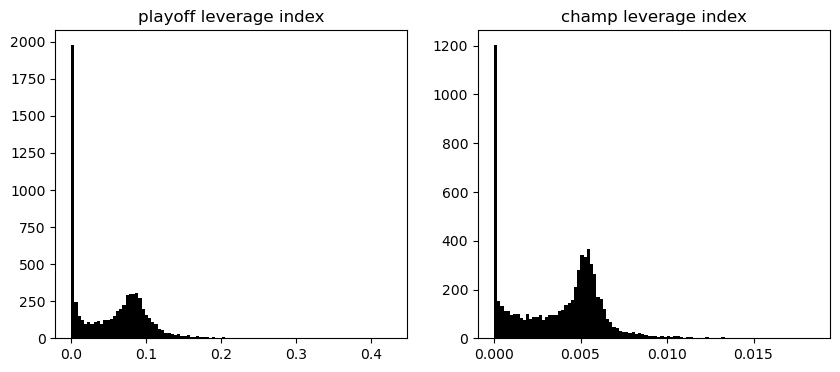

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
for kind, i in zip(["playoff", "champ"], range(2)):
    # Yes, I know the columns are named sort of wrong
    # because cli is champ leverage index
    # but eh just think of cli as a type of stat
    # and champ cli as a special incarnation of cli
    temp_data = pd.concat([df[f"home_{kind}_cli"], df[f"away_{kind}_cli"]])
    ax[i].hist(temp_data, bins=100, color="black")
    ax[i].set_title(f"{kind} leverage index")
plt.show()

# Prelim puzzle

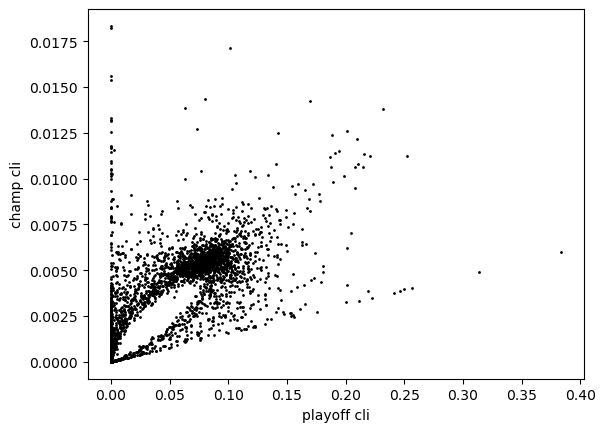

In [5]:
fig, ax = plt.subplots()
ax.scatter(df["home_playoff_cli"], df["home_champ_cli"], s=1, color="black")
ax.set_xlabel("playoff cli")
ax.set_ylabel("champ cli")
plt.show()

In [6]:
# First need to add ranks to the dataframe
conference_df = pd.read_csv("data/conferences.csv")
conf_lists = {
    "east": conference_df[conference_df["conference"] == "East"]["team"].to_list(),
    "west": conference_df[conference_df["conference"] == "West"]["team"].to_list(),
}
team_names = conference_df["team"].to_list()


def get_comp_rank(df, index):
    home, away = df.loc[index, "home"], df.loc[index, "away"]
    home_conf = "east" if home in conf_lists["east"] else "west"
    away_conf = "east" if away in conf_lists["east"] else "west"
    season_games_prior = df[ # i.e., games in the same season, earlier time
        (df["season_num"] == df.loc[index, "season_num"])
        & (df.index < index)
    ]
    standings = pd.Series(0, index=team_names)
    standings = (standings + season_games_prior["winner_x"].value_counts()).fillna(0)
    standings += np.random.uniform(0, 0.001, len(standings)) # Noise to break ties
    conf_standings = {
        "east": standings.loc[conf_lists["east"]].sort_values(ascending=False),
        "west": standings.loc[conf_lists["west"]].sort_values(ascending=False)
    }
    home_rank = conf_standings[home_conf].index.tolist().index(home) + 1
    away_rank = conf_standings[away_conf].index.tolist().index(away) + 1
    return home_rank, away_rank

In [7]:
home_away_ranks = pd.DataFrame(
    [get_comp_rank(df, index) for index in df.index],
    columns=["home_rank", "away_rank"]
)
df = pd.concat([df, home_away_ranks], axis=1)

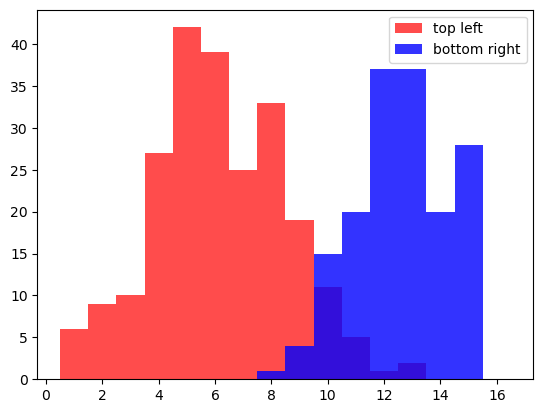

In [8]:
top_left = df[
    (df["home_playoff_cli"] < 0.01)
    & (df["home_champ_cli"] > 0.002)
]
bot_right = df[
    (df["home_playoff_cli"] > 0.05)
    & (df["home_champ_cli"]< 0.003)
]

fig, ax = plt.subplots()
bins = np.arange(0.5, 16.51, 1)
ax.hist(top_left["home_rank"], bins=bins, color="red", alpha=0.7)
ax.hist(bot_right["home_rank"], bins=bins, color="blue", alpha=0.8)
ax.legend(["top left", "bottom right"])
plt.show()

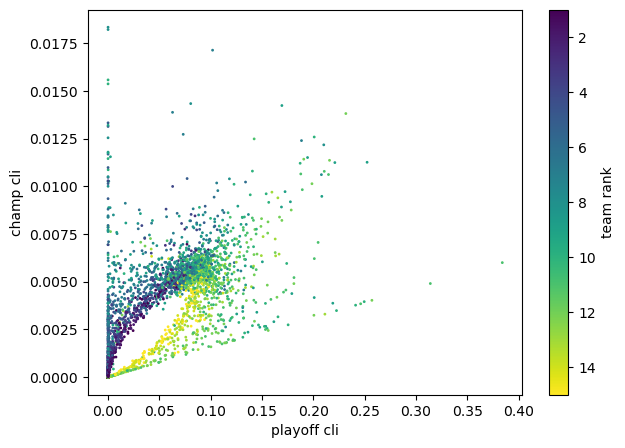

In [9]:
fig, ax = plt.subplots(figsize=(7, 5))
scatter = ax.scatter(df["home_playoff_cli"], df["home_champ_cli"], s=1, c=df["home_rank"])
colourbar = fig.colorbar(scatter, ax=ax, label="team rank")
colourbar.ax.invert_yaxis()
ax.set_xlabel("playoff cli")
ax.set_ylabel("champ cli")
plt.show()

# Trading

In [10]:
def get_sharpe(s): return s.sum() / (s ** 2).sum() ** 0.5

In [11]:
def get_mean_pnl_centre(df, home_centre, away_centre, cli_type, radius, direction):
    # NOTE: radius should be larger for playoff cli than champ cli
    distance = (
        (df[f"home_{cli_type}_cli"] - home_centre) ** 2
        + (df[f"away_{cli_type}_cli"] - away_centre) ** 2
    )
    weights = np.exp(-distance / radius)
    pnl = df[f"{direction}_home_pnl"] * weights
    sharpe = get_sharpe(pnl)
    return sharpe, pnl.sum(), weights.sum()

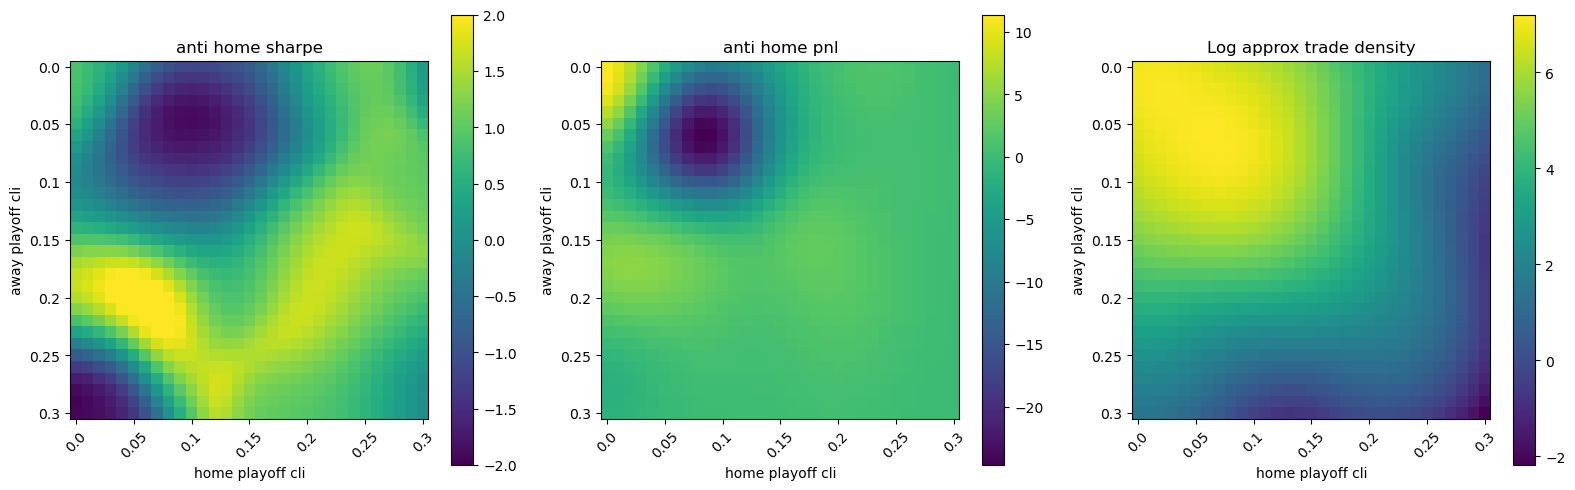

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
home_ticks = np.arange(0, 0.3001, 0.01)
away_ticks = np.arange(0, 0.3001, 0.01)
cli_type = "playoff"
radius = 0.003
direction = "anti"

temp_np = np.array([
    [
        get_mean_pnl_centre(df, home_centre, away_centre, cli_type, radius, direction)
        for home_centre in home_ticks
    ]
    for away_centre in away_ticks
])
sharpe_df = pd.DataFrame(temp_np[:,:,0], index=away_ticks, columns=home_ticks)
pnl_df = pd.DataFrame(temp_np[:,:,1], index=away_ticks, columns=home_ticks)
count_df = pd.DataFrame(np.log(temp_np[:,:,2]), index=away_ticks, columns=home_ticks)

im_0 = ax[0].imshow(sharpe_df, vmin=-2, vmax=2)
im_1 = ax[1].imshow(pnl_df)
im_2 = ax[2].imshow(count_df)
for im in [im_0, im_1, im_2]:
    plt.colorbar(im)
for i in range(3):
    ax[i].set_xlabel(f"home {cli_type} cli")
    ax[i].set_ylabel(f"away {cli_type} cli")
    cut = 5
    ax[i].set_xticks(list(range(len(home_ticks)))[::cut], np.round(home_ticks[::cut], decimals=2), rotation=45)
    ax[i].set_yticks(list(range(len(away_ticks)))[::cut], np.round(away_ticks[::cut], decimals=2))
ax[0].set_title(f"{direction} home sharpe")
ax[1].set_title(f"{direction} home pnl")
ax[2].set_title("Log approx trade density")
plt.tight_layout()
plt.show()

## 1.

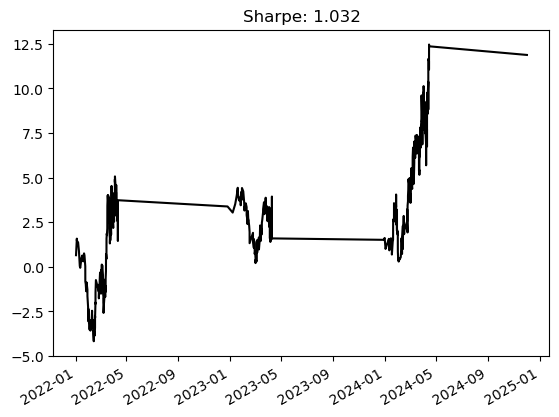

In [13]:
trim_df = df[(df["home_playoff_cli"] < 0.01) & (df["away_playoff_cli"] < 0.01)]
fig, ax = plt.subplots()
ax.plot(pd.to_datetime(trim_df["time"]), trim_df["anti_home_pnl"].cumsum(), color="black")
ax.set_title(f"Sharpe: {get_sharpe(trim_df['anti_home_pnl']):.3f}")
plt.gcf().autofmt_xdate()
plt.show()

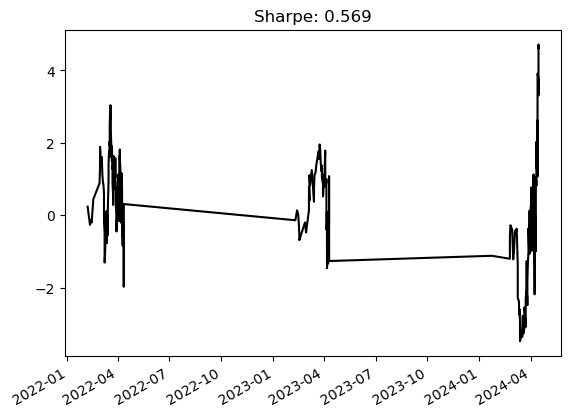

In [14]:
trim_df = df[(df["home_playoff_cli"] == 0.0) & (df["away_playoff_cli"] == 0.0)]
fig, ax = plt.subplots()
ax.plot(pd.to_datetime(trim_df["time"]), trim_df["anti_home_pnl"].cumsum(), color="black")
ax.set_title(f"Sharpe: {get_sharpe(trim_df['anti_home_pnl']):.3f}")
plt.gcf().autofmt_xdate()
plt.show()

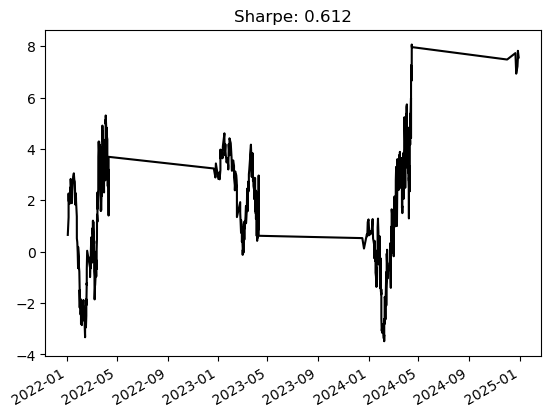

In [15]:
trim_df = df[(df["home_playoff_cli"] < 0.02) & (df["away_playoff_cli"] < 0.02)]
fig, ax = plt.subplots()
ax.plot(pd.to_datetime(trim_df["time"]), trim_df["anti_home_pnl"].cumsum(), color="black")
ax.set_title(f"Sharpe: {get_sharpe(trim_df['anti_home_pnl']):.3f}")
plt.gcf().autofmt_xdate()
plt.show()

## 2. 

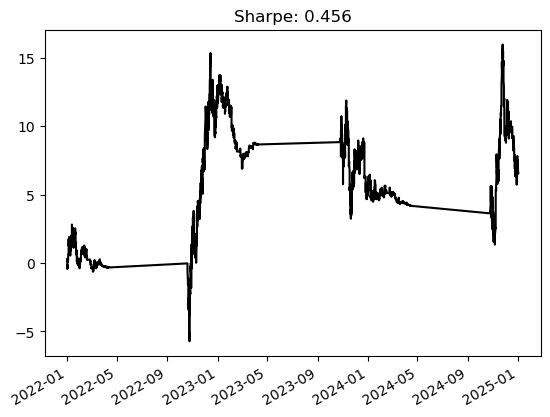

In [16]:
# Black hole at 0.08, 0.08
distance = (
    (df["home_playoff_cli"] - 0.08) ** 2
    + (df["away_playoff_cli"] - 0.08) ** 2
)
weights = np.exp(-distance / 0.003)
pnl = weights * df["pro_home_pnl"]

fig, ax = plt.subplots()
ax.plot(pd.to_datetime(df["time"]), pnl.cumsum(), color="black")
ax.set_title(f"Sharpe: {get_sharpe(pnl):.3f}")
plt.gcf().autofmt_xdate()
plt.show()

## 3. 

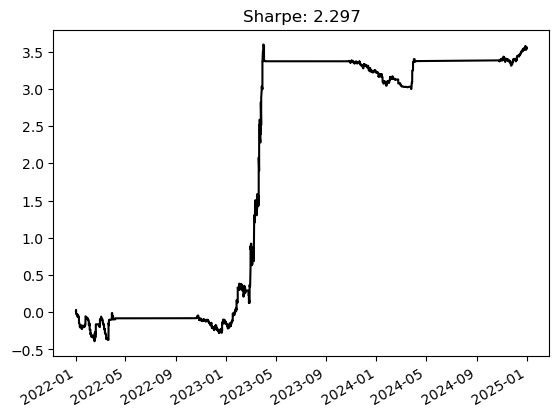

In [17]:
distance = (
    (df["home_playoff_cli"] - 0.05) ** 2
    + (df["away_playoff_cli"] - 0.2) ** 2
)
df["weight"] = np.exp(-distance / 0.003)
df["pnl"] = df["weight"] * df["anti_home_pnl"]
pnl = df["pnl"]

fig, ax = plt.subplots()
ax.plot(pd.to_datetime(df["time"]), pnl.cumsum(), color="black")
ax.set_title(f"Sharpe: {get_sharpe(pnl):.3f}")
plt.gcf().autofmt_xdate()
plt.show()

In [18]:
df.sort_values(by="weight", ascending=False).head(20).T

,1633,1703,1740,1732,1717,1726,1655,485,1763,1631,1690,585,1696,580,1769,1551,1783,1579,601,1695
filepath,market_data/2023/BASIC 4/2023/Mar/10/32167053/...,market_data/2023/BASIC 4/2023/Mar/22/32199379/...,market_data/2023/BASIC 4/2023/Mar/27/32212495/...,market_data/2023/BASIC 4/2023/Mar/26/32209738/...,market_data/2023/BASIC 7/2023/Mar/24/32204287/...,market_data/2023/BASIC 7/2023/Mar/25/32207319/...,market_data/2023/BASIC 4/2023/Mar/14/32177992/...,market_data/2022/BASIC 2/2022/Mar/15/31299178/...,market_data/2023/BASIC 4/2023/Mar/30/32220515/...,market_data/2023/BASIC 4/2023/Mar/9/32164241/1...,market_data/2023/BASIC 4/2023/Mar/20/32193720/...,market_data/2022/BASIC 2/2022/Mar/30/31333690/...,market_data/2023/BASIC 4/2023/Mar/21/32196442/...,market_data/2022/BASIC 2/2022/Mar/29/31330592/...,market_data/2023/BASIC 6/2023/Apr/1/32225809/1...,market_data/2023/BASIC 4/2023/Feb/25/32113150/...,market_data/2023/BASIC 6/2023/Apr/2/32231143/1...,market_data/2023/BASIC 7/2023/Mar/1/32142271/1...,market_data/2022/BASIC 2/2022/Apr/1/31338343/1...,market_data/2023/BASIC 7/2023/Mar/21/32196489/...
mkt_type,MATCH_ODDS,MATCH_ODDS,MATCH_ODDS,MATCH_ODDS,MATCH_ODDS,MATCH_ODDS,MATCH_ODDS,MATCH_ODDS,MATCH_ODDS,MATCH_ODDS,MATCH_ODDS,MATCH_ODDS,MATCH_ODDS,MATCH_ODDS,MATCH_ODDS,MATCH_ODDS,MATCH_ODDS,MATCH_ODDS,MATCH_ODDS,MATCH_ODDS
name,Utah Jazz @ Orlando Magic,Oklahoma City Thunder @ LA Clippers,Oklahoma City Thunder @ Portland Trail Blazers,New Orleans Pelicans @ LA Clippers,Oklahoma City Thunder @ LA Clippers,Chicago Bulls @ Portland Trail Blazers,Utah Jazz @ Miami Heat,Portland Trail Blazers @ Atlanta Hawks,Los Angeles Lakers @ Chicago Bulls,Oklahoma City Thunder @ Phoenix Suns,New Orleans Pelicans @ Houston Rockets,Los Angeles Lakers @ Dallas Mavericks,Minnesota Timberwolves @ New York Knicks,San Antonio Spurs @ Houston Rockets,Utah Jazz @ Boston Celtics,Oklahoma City Thunder @ Phoenix Suns,Utah Jazz @ Brooklyn Nets,Minnesota Timberwolves @ LA Clippers,Los Angeles Lakers @ Utah Jazz,Chicago Bulls @ Philadelphia 76ers
time,2023-03-10T00:10:00.000Z,2023-03-22T02:40:00.000Z,2023-03-26T23:10:00.000Z,2023-03-26T02:40:00.000Z,2023-03-24T02:40:00.000Z,2023-03-25T02:10:00.000Z,2023-03-13T23:40:00.000Z,2022-03-14T23:40:00.000Z,2023-03-30T00:10:00.000Z,2023-03-09T02:10:00.000Z,2023-03-19T23:10:00.000Z,2022-03-29T23:30:00.000Z,2023-03-20T23:40:00.000Z,2022-03-29T00:10:00.000Z,2023-03-31T23:40:00.000Z,2023-02-25T03:10:00.000Z,2023-04-02T19:40:00.000Z,2023-03-01T03:00:00.000Z,2022-04-01T02:00:00.000Z,2023-03-20T23:10:00.000Z
home,Orlando Magic,LA Clippers,Portland Trail Blazers,LA Clippers,LA Clippers,Portland Trail Blazers,Miami Heat,Atlanta Hawks,Chicago Bulls,Phoenix Suns,Houston Rockets,Dallas Mavericks,New York Knicks,Houston Rockets,Boston Celtics,Phoenix Suns,Brooklyn Nets,LA Clippers,Utah Jazz,Philadelphia 76ers
away,Utah Jazz,Oklahoma City Thunder,Oklahoma City Thunder,New Orleans Pelicans,Oklahoma City Thunder,Chicago Bulls,Utah Jazz,Portland Trail Blazers,Los Angeles Lakers,Oklahoma City Thunder,New Orleans Pelicans,Los Angeles Lakers,Minnesota Timberwolves,San Antonio Spurs,Utah Jazz,Oklahoma City Thunder,Utah Jazz,Minnesota Timberwolves,Los Angeles Lakers,Chicago Bulls
us_time,2023-03-09 18:10:00-06:00,2023-03-21 21:40:00-05:00,2023-03-26 18:10:00-05:00,2023-03-25 21:40:00-05:00,2023-03-23 21:40:00-05:00,2023-03-24 21:10:00-05:00,2023-03-13 18:40:00-05:00,2022-03-14 18:40:00-05:00,2023-03-29 19:10:00-05:00,2023-03-08 20:10:00-06:00,2023-03-19 18:10:00-05:00,2022-03-29 18:30:00-05:00,2023-03-20 18:40:00-05:00,2022-03-28 19:10:00-05:00,2023-03-31 18:40:00-05:00,2023-02-24 21:10:00-06:00,2023-04-02 14:40:00-05:00,2023-02-28 21:00:00-06:00,2022-03-31 21:00:00-05:00,2023-03-20 18:10:00-05:00
date,2023-03-09,2023-03-21,2023-03-26,2023-03-25,2023-03-23,2023-03-24,2023-03-13,2022-03-14,2023-03-29,2023-03-08,2023-03-19,2022-03-29,2023-03-20,2022-03-28,2023-03-31,2023-02-24,2023-04-02,2023-02-28,2022-03-31,2023-03-20
home_ask,0.625,0.699301,0.181818

## 4. 

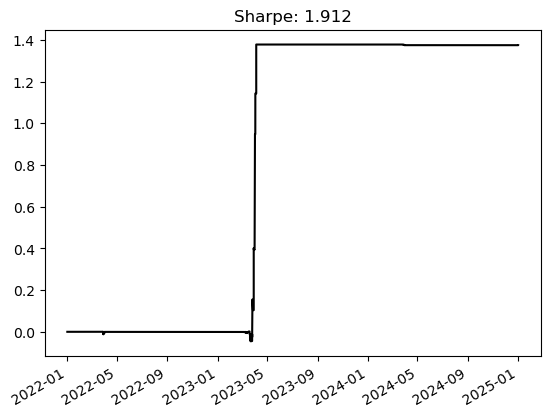

In [19]:
distance = (
    (df["home_playoff_cli"] - 0.0) ** 2
    + (df["away_playoff_cli"] - 0.3) ** 2
)
df["weight"] = np.exp(-distance / 0.003)
pnl = df["weight"] * df["pro_home_pnl"]

fig, ax = plt.subplots()
ax.plot(pd.to_datetime(df["time"]), pnl.cumsum(), color="black")
ax.set_title(f"Sharpe: {get_sharpe(pnl):.3f}")
plt.gcf().autofmt_xdate()
plt.show()

In [20]:
df.sort_values(by="weight", ascending=False).head(10)

,filepath,mkt_type,name,time,home,away,us_time,date,home_ask,home_bid,...,synth_home_mid,anti_home_pnl,pro_home_pnl,date_mod_year,weekday,is_weekend,home_rank,away_rank,weight,pnl
1778,market_data/2023/BASIC 6/2023/Apr/2/32228285/1...,MATCH_ODDS,Dallas Mavericks @ Miami Heat,2023-04-01T23:40:00.000Z,Miami Heat,Dallas Mavericks,2023-04-01 18:40:00-05:00,2023-04-01,0.446429,0.438596,...,0.443055,-0.561404,0.552486,2000-04-01 23:40:00+00:00,5,True,7,12,0.997201,-0.010531
1805,market_data/2023/BASIC 6/2023/Apr/5/32233884/1...,MATCH_ODDS,Oklahoma City Thunder @ Golden State Warriors,2023-04-05T02:10:00.000Z,Golden State Warriors,Oklahoma City Thunder,2023-04-04 21:10:00-05:00,2023-04-04,0.757576,0.740741,...,0.749158,-0.259259,0.242424,2000-04-05 02:10:00+00:00,1,False,6,10,0.968494,-0.007482
1758,market_data/2023/BASIC 4/2023/Mar/30/32220555/...,MATCH_ODDS,Dallas Mavericks @ Philadelphia 76ers,2023-03-29T23:40:00.000Z,Philadelphia 76ers,Dallas Mavericks,2023-03-29 18:40:00-05:00,2023-03-29,0.666667,0.657895,...,0.663265,-0.340136,0.333333,2000-03-29 23:40:00+00:00,2,False,3,10,0.892184,-0.016150
1784,market_data/2023/BASIC 6/2023/Apr/3/32231056/1...,MATCH_ODDS,Dallas Mavericks @ Atlanta Hawks,2023-04-02T22:10:00.000Z,Atlanta Hawks,Dallas Mavericks,2023-04-02 17:10:00-05:00,2023-04-02,0.591716,0.584795,...,0.588256,-0.415205,0.408284,2000-04-02 22:10:00+00:00,6,True,9,11,0.444485,-0.096666
1733,market_data/2023/BASIC 7/2023/Mar/26/32212657/...,MATCH_ODDS,Dallas Mavericks @ Charlotte Hornets,2023-03-26T17:10:00.000Z,Charlotte Hornets,Dallas Mavericks,2023-03-26 12:10:00-05:00,2023-03-26,0.156250,0.142857,...,0.149554,-0.857143,0.843750,2000-03-26 17:10:00+00:00,6,True,14,12,0.214095,-0.264790
1730,market_data/2023/BASIC 4/2023/Mar/26/32209736/...,MATCH_ODDS,Utah Jazz @ Sacramento Kings,2023-03-26T02:10:00.000Z,Sacramento Kings,Utah Jazz,2023-03-25 21:10:00-05:00,2023-03-25,0.806452,0.781250,...,0.796843,-0.212766,0.193548,2000-03-26 02:10:00+00:00,5,True,3,10,0.170083,-0.072389
1742,market_data/2023/BASIC 7/2023/Mar/28/32215409/...,MATCH_ODDS,Dallas Mavericks @ Indiana Pacers,2023-03-27T23:10:00.000Z,Indiana Pacers,Dallas Mavericks,2023-03-27 18:10:00-05:00,2023-03-27,0.273973,0.270270,...,0.272816,0.270270,-0.275362,2000-03-27 23:10:00+00:00,0,False,11,10,0.141147,0.088070
601,market_data/2022/BASIC 2/2022/Apr/1/31338343/1...,MATCH_ODDS,Los Angeles Lakers @ Utah Jazz,2022-04-01T02:00:00.000Z,Utah Jazz,Los Angeles Lakers,2022-03-31 21:00:00-05:00,2022-03-31,0.909091,0.892857,...,0.901354,-0.106383,0.090909,2000-04-01 02:00:00+00:00,3,False,7,12,0.066403,-0.044777
1740,market_data/2023/BASIC 4/2023/Mar/27/32212495/...,MATCH_ODDS,Oklahoma City Thunder @ Portland Trail Blazers,2023-03-26T23:10:00.000Z,Portland Trail Blazers,Oklahoma City Thunder,2023-03-26 18:10:00-05:00,2023-03-26,0.181818,0.178571,...,0.183660,0.180328,-0.186992,2000-03-26 23:10:00+00:00,6,True,13,8,0.064943,0.154038
1783,market_data/2023/BASIC 6/2023/Apr/2/32231143/1...,MATCH_ODDS,Utah Jazz @ Brooklyn Nets,2023-04-02T19:40:00.000Z,Brooklyn Nets,Utah Jazz,2023-04-02 14:40:00-05:00,2023-04-02,0.757576,0.740741,...,0.749158,-0.259259,0.242424,2000-04-02 19:40:00+00:00,6,True,6,12,0.056664,-0.110743


## 5.

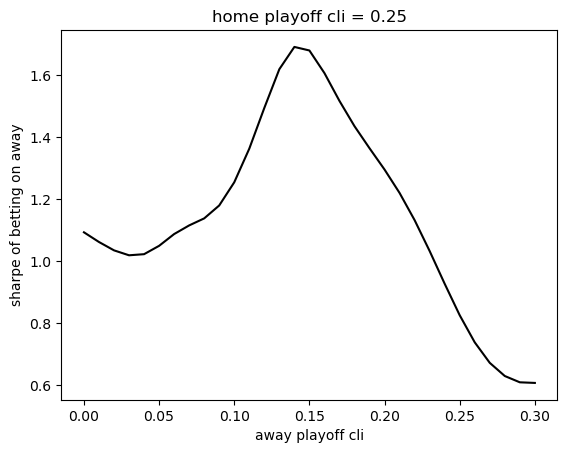

In [21]:
fig, ax = plt.subplots()
ax.plot(sharpe_df.index, sharpe_df[0.25], color="black")
ax.set_xlabel("away playoff cli")
ax.set_ylabel("sharpe of betting on away")
ax.set_title("home playoff cli = 0.25")
plt.show()

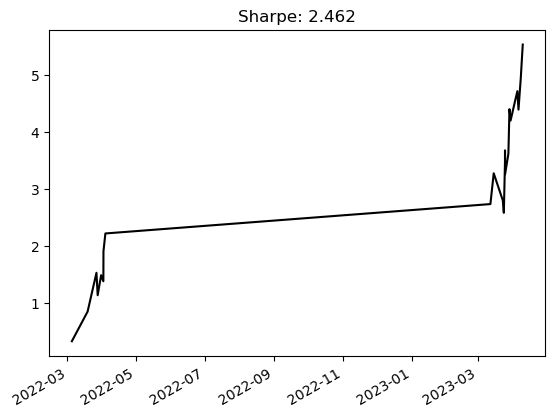

In [22]:
fig, ax = plt.subplots()
trim_df = df[df["home_playoff_cli"] > 0.2].copy()
pnl = trim_df["anti_home_pnl"]
ax.plot(pd.to_datetime(trim_df["time"]), pnl.cumsum(), color="black")
ax.set_title(f"Sharpe: {get_sharpe(pnl):.3f}")
plt.gcf().autofmt_xdate()
plt.show()

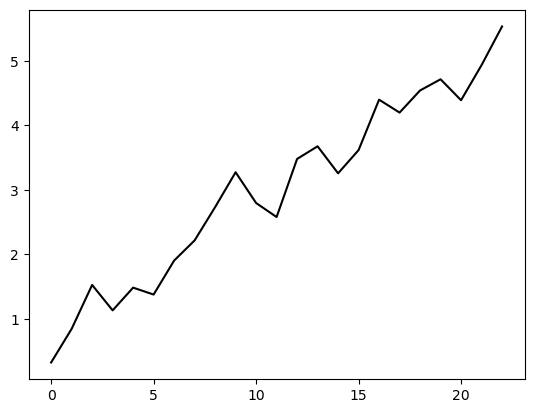

In [25]:
plt.plot(range(len(pnl)), pnl.cumsum(), color="black")

# Champ cli

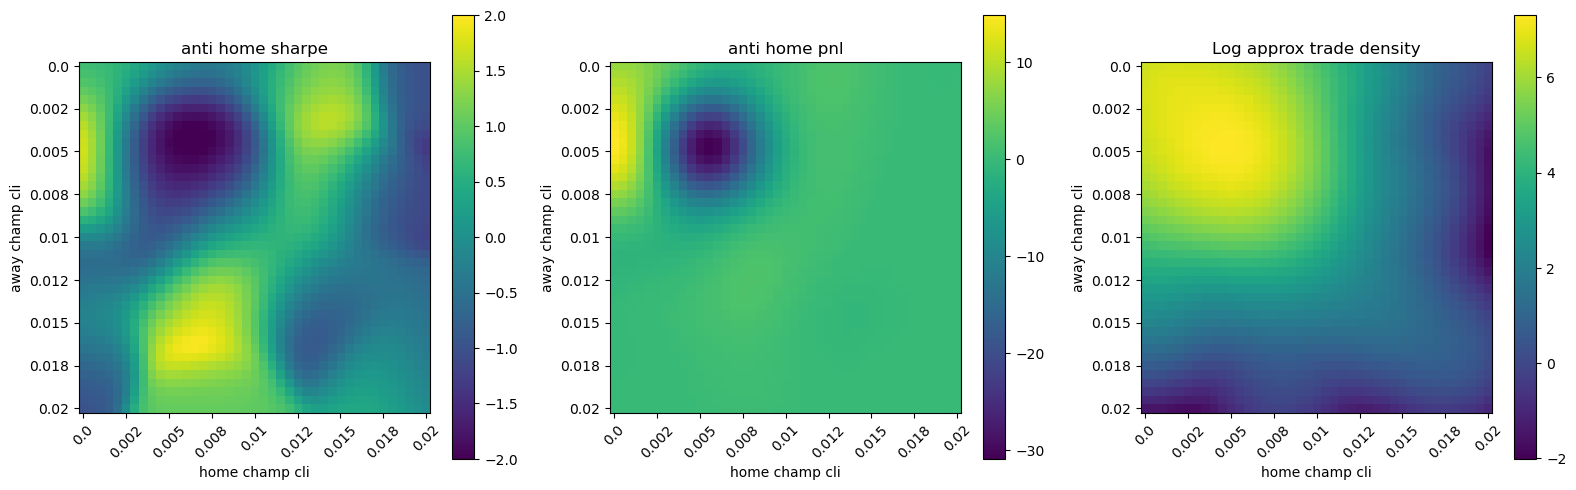

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
home_ticks = np.arange(0, 0.0201, 0.0005)
away_ticks = np.arange(0, 0.0201, 0.0005)
cli_type = "champ"
radius = 0.00001
direction = "anti"

temp_np = np.array([
    [
        get_mean_pnl_centre(df, home_centre, away_centre, cli_type, radius, direction)
        for home_centre in home_ticks
    ]
    for away_centre in away_ticks
])
sharpe_df = pd.DataFrame(temp_np[:,:,0], index=away_ticks, columns=home_ticks)
pnl_df = pd.DataFrame(temp_np[:,:,1], index=away_ticks, columns=home_ticks)
count_df = pd.DataFrame(np.log(temp_np[:,:,2]), index=away_ticks, columns=home_ticks)

im_0 = ax[0].imshow(sharpe_df, vmin=-2, vmax=2)
im_1 = ax[1].imshow(pnl_df)
im_2 = ax[2].imshow(count_df)
for im in [im_0, im_1, im_2]:
    plt.colorbar(im)
for i in range(3):
    ax[i].set_xlabel(f"home {cli_type} cli")
    ax[i].set_ylabel(f"away {cli_type} cli")
    cut = 5
    ax[i].set_xticks(list(range(len(home_ticks)))[::cut], np.round(home_ticks[::cut], decimals=3), rotation=45)
    ax[i].set_yticks(list(range(len(away_ticks)))[::cut], np.round(away_ticks[::cut], decimals=3))
ax[0].set_title(f"{direction} home sharpe")
ax[1].set_title(f"{direction} home pnl")
ax[2].set_title("Log approx trade density")
plt.tight_layout()
plt.show()